In [1]:
!pip install wavemix
!pip install torchinfo
!pip install torchmetrics
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

In [11]:
!wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=pranavphoenix&password=Newton@13&submit=Login' https://www.cityscapes-dataset.com/login/
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1

--2024-04-25 23:15:59--  https://www.cityscapes-dataset.com/login/
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cityscapes-dataset.com/downloads/ [following]
--2024-04-25 23:16:00--  https://www.cityscapes-dataset.com/downloads/
Reusing existing connection to www.cityscapes-dataset.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index.html.4’

index.html.4            [  <=>               ]  57.34K   181KB/s    in 0.3s    

2024-04-25 23:16:01 (181 KB/s) - ‘index.html.4’ saved [58715]

--2024-04-25 23:16:01--  https://www.cityscapes-dataset.com/file-handling/?packageID=3
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.2

In [6]:
!unzip -q /content/gtFine_trainvaltest.zip
!unzip -q /content/leftImg8bit_trainvaltest.zip

replace README? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


torch.Size([3, 1024, 2048]) torch.Size([1024, 2048])
tensor([ 1,  3,  4,  5,  7,  8,  9, 11, 13, 17, 18, 19, 20, 21, 22, 23, 26],
       dtype=torch.uint8)
17
torch.Size([1024, 2048])
tensor([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 14], dtype=torch.uint8)
12
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)
2975
500


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyboardInterrupt: 

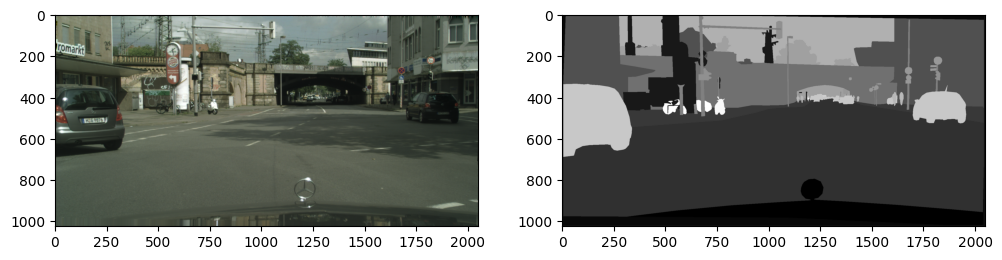

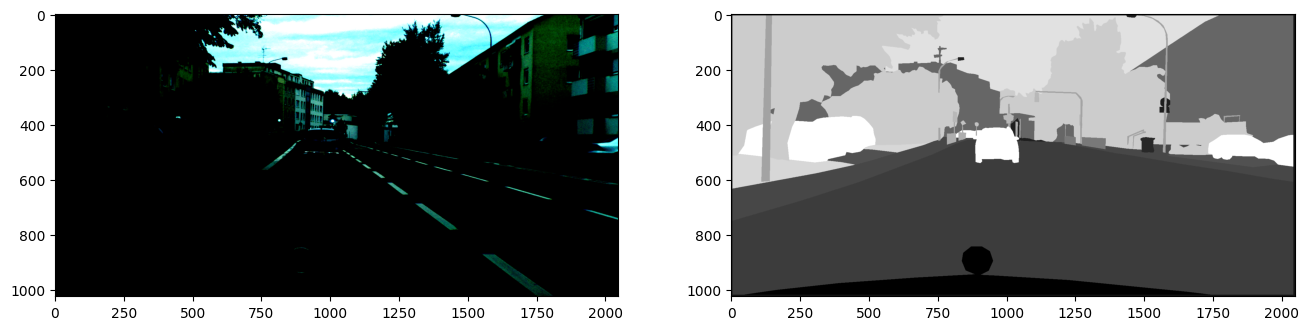

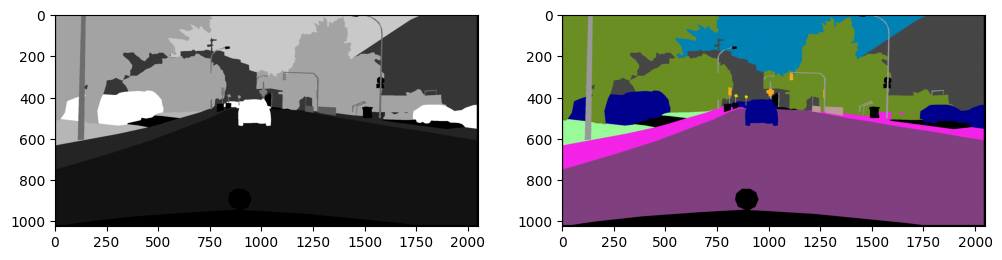

In [35]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_properties(device))
torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True

import sys, os, time, pickle
import numpy as np
import math
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

import torch.optim as optim

from torchsummary import summary

from math import ceil
import pywt

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

from torch import nn, einsum
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers
from einops import reduce


dataset = torchvision.datasets.Cityscapes('/content/', split='train', mode='fine',
                      target_type='semantic')
dataset[0][0].size

fig,ax=plt.subplots(ncols=2,figsize=(12,8))
ax[0].imshow(dataset[0][0])
ax[1].imshow(dataset[0][1],cmap='gray')

ignore_index=255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index,7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']


class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_map

colors = [   [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colours = dict(zip(range(n_classes), colors))

def encode_segmap(mask):
    #remove unwanted classes and recitify the labels of wanted classes
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

def decode_segmap(temp):
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

# !pip uninstall opencv-python-headless==4.5.5.62



import albumentations as A
from albumentations.pytorch import ToTensorV2

transform=A.Compose(
[
    A.Resize(1024, 2048),
    A.HorizontalFlip(0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)

from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from torchvision.datasets import Cityscapes

class MyClass(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image = Image.open(self.images[index]).convert('RGB')

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])
            targets.append(target)
        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            transformed=transform(image=np.array(image), mask=np.array(target))
        return transformed['image'],transformed['mask']

dataset=MyClass('/content/', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
img,seg= dataset[20]
print(img.shape,seg.shape)

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(seg,cmap='gray')

print(torch.unique(seg))
print(len(torch.unique(seg)))

res=encode_segmap(seg.clone())
print(res.shape)
print(torch.unique(res))
print(len(torch.unique(res)))

res1=decode_segmap(res.clone())

fig,ax=plt.subplots(ncols=2,figsize=(12,10))
ax[0].imshow(res,cmap='gray')
ax[1].imshow(res1)

import torch
import torch.nn.functional as F
import numpy as np
from torch.autograd import Function
import pywt
import torch.nn as nn
import functools
import segmentation_models_pytorch as smp

# !pip uninstall torchmetrics

import torchmetrics
###################MODEL################################################################

import torch, wavemix
from wavemix.classification import WaveMix

import torch, wavemix
from wavemix.classification import WaveMix

model = WaveMix(
    num_classes = 1000,
    depth = 16,
    mult = 2,
    ff_channel = 192,
    final_dim = 192,
    dropout = 0.5,
    level = 3,
    initial_conv = 'pachify',
    patch_size = 4
)

model.pool = nn.Sequential(
            nn.ConvTranspose2d(192 , 128, 4, stride=2, padding=1),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.Conv2d(64, 20, 1)
)

url = 'https://huggingface.co/cloudwalker/wavemix/resolve/main/Saved_Models_Weights/cityscapes_83.04.pth'

model.load_state_dict(torch.hub.load_state_dict_from_url(url))

model.to(device)

# print(summary(model, (3,1024, 2048)))


print(torch.cuda.get_device_properties(device))


from torch.autograd import Variable
class FocalLoss2d(nn.Module):
    def __init__(self, gamma=2, weight=None, size_average=True):
        super(FocalLoss2d, self).__init__()

        self.gamma = gamma
        self.weight = weight
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.contiguous().view(input.size(0), input.size(1), -1)
            input = input.transpose(1,2)
            input = input.contiguous().view(-1, input.size(2)).squeeze()
        if target.dim()==4:
            target = target.contiguous().view(target.size(0), target.size(1), -1)
            target = target.transpose(1,2)
            target = target.contiguous().view(-1, target.size(2)).squeeze()
        elif target.dim()==3:
            target = target.view(-1)
        else:
            target = target.view(-1, 1)

        weight = Variable(self.weight)
        logpt = -F.cross_entropy(input, target)
        pt = torch.exp(logpt)

        loss = -((1-pt)**self.gamma) * logpt

        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

#criterion= smp.losses.DiceLoss(mode='multiclass')
# metrics = torchmetrics.IoU(num_classes=n_classes)

trainset = MyClass('/content/', split='train', mode='fine',
                     target_type='semantic',transforms=transform)

testset= MyClass('/content/', split='val', mode='fine',
                     target_type='semantic',transforms=transform)

batch_size = 1


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=True, prefetch_factor=2, persistent_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, pin_memory=True, prefetch_factor=2, persistent_workers=2)

SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    # outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    outputs = outputs.argmax(dim=1)

    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    # return thresholded  # Or thresholded.mean() if you are interested in average across the batch
    return iou




print(len(trainset))
print(len(testset))

criterion = FocalLoss2d()
scaler = torch.cuda.amp.GradScaler()
from tqdm import tqdm
miou = []
epoch_losses = []
test_losses = []
traintime = []
testtime = []
counter = 0
epoch = 0
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
while counter < 25:  # loop over the dataset multiple times
    t0 = time.time()
    epoch_accuracy = 0
    epoch_loss = 0
    running_loss = 0.0

    model.train()

    # with tqdm(trainloader, unit="batch") as tepoch:
    #     tepoch.set_description(f"Epoch {epoch+1}")

    #     for data in tepoch:



    #         inputs, labels = data[0].to(device), data[1].to(device)
    #         # labels = labels.long()
    #         optimizer.zero_grad()
    #         outputs = model(inputs)
    #         segment=encode_segmap(labels)

    #         with torch.cuda.amp.autocast():
    #             loss = criterion(outputs, segment.long())
    #         scaler.scale(loss).backward()
    #         scaler.step(optimizer)
    #         scaler.update()


    #         acc = (outputs.argmax(dim=1) == labels).float().mean()
    #         epoch_accuracy += acc / len(trainloader)
    #         epoch_loss += loss / len(trainloader)


    #         running_loss += loss.item()


    #         tepoch.set_postfix_str(f" loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}" )

    # epoch_losses.append(epoch_loss)
    test_loss = 0
    total = 0

    mIoU = 0
    model.eval()
    with torch.no_grad():
        t1 = time.time()
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # labels = labels.squeeze(1).long()
            outputs = model(images)
            segment=encode_segmap(labels)
#         outputs = net(images)

            # _, predicted = torch.max(outputs.data, 1)
            with torch.cuda.amp.autocast():
              test_loss += criterion(outputs, segment.long())
              # mIoU = metrics(outputs, labels)
              # mIoU +=  metrics(outputs,segment)
            mIoU += iou_pytorch(outputs, segment).mean()
            # mIoU += mean_iou(outputs, segment)


    mIoU = mIoU/len(testloader)
    test = test_loss/len(testloader)
    test_losses.append(test)
    mIoU = mIoU.cpu().detach()
    miou.append(mIoU)
    traintime.append(t1 - t0)
    testtime.append(time.time() - t1)
    counter += 1
    epoch += 1

    print(f"Epoch : {epoch+1} - MIOU: {mIoU:.4f} -Test Time: {time.time() - t1:.0f} \n")
    if mIoU >= max(miou):
        PATH = 'cityscapes.pth'
        torch.save(model.state_dict(), PATH)
        print(1)
        counter = 0


# print('Finished Training')
# PATH = 'cityscapes_82.44.pth'
# PATH = 'pretrainedmodel.pth'
# PATH = 'cityscapes.pth'
model.load_state_dict(torch.load(PATH))
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
for epoch in range(100):  # loop over the dataset multiple times
    t0 = time.time()
    epoch_accuracy = 0
    epoch_loss = 0
    running_loss = 0.0

    model.train()

    with tqdm(trainloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}")

        for data in tepoch:


        # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            segment=encode_segmap(labels)

            with torch.cuda.amp.autocast():
                loss = criterion(outputs, segment.long())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()


            acc = (outputs.argmax(dim=1) == labels).float().mean()
            epoch_accuracy += acc / len(trainloader)
            epoch_loss += loss / len(trainloader)

            # print statistics
            running_loss += loss.item()
            # if i % 200 == 199:    # print every 2000 mini-batches
            #     print('[%d, %5d] loss: %.3f' %
            #         (epoch + 1, i + 1, running_loss / 2000))
            #     running_loss = 0.0

            tepoch.set_postfix_str(f" loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}" )
    epoch_losses.append(epoch_loss)
    test_loss = 0
    total = 0

    mIoU = 0
    model.eval()
    with torch.no_grad():
        t1 = time.time()
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)

            outputs = model(images)
            segment=encode_segmap(labels)
#
            with torch.cuda.amp.autocast():
              test_loss += criterion(outputs, segment.long())

            mIoU += iou_pytorch(outputs, segment).mean()


    mIoU = mIoU/len(testloader)
    test = test_loss/len(testloader)
    test_losses.append(test)
    mIoU = mIoU.cpu().detach()
    miou.append(mIoU)

    traintime.append(t1 - t0)
    testtime.append(time.time() - t1)

    print(f"Epoch : {epoch+1} - MIOU: {mIoU:.4f} -Test Time: {time.time() - t1:.0f} \n")
    if mIoU >= max(miou):
        PATH = 'cityscapes.pth'
        torch.save(model.state_dict(), PATH)
        print(1)

print('Finished Training')
print(f"Top mIoU : {max(miou):.4f} - Train Time: {min(traintime):.0f} -Test Time: {min(testtime):.0f}\n")



In [51]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    # outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    outputs = outputs.argmax(dim=1)

    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    # return thresholded  # Or thresholded.mean() if you are interested in average across the batch
    return iou, thresholded


In [ ]:
test_class = MyClass('/content/', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
test_loader=torch.utils.data.DataLoader(test_class, batch_size=1,
                      shuffle=True)
mIoU = 0
model.eval()
with torch.no_grad():
    for batch in test_loader:
        img,seg=batch
        output=model(img.cuda())
        segment=encode_segmap(seg.cuda())
        mIoU, miou = iou_pytorch(output, segment)
        # mIoU = iou_pytorch(output, torch.argmax(output, dim=1))
        print(mIoU, miou)
        if mIoU < 0.5:
          break
print(img.shape,seg.shape,output.shape)





tensor([0.9057], device='cuda:0') tensor([0.9000], device='cuda:0')
tensor([0.9687], device='cuda:0') tensor([1.], device='cuda:0')
tensor([0.9339], device='cuda:0') tensor([0.9000], device='cuda:0')
tensor([0.9348], device='cuda:0') tensor([0.9000], device='cuda:0')
tensor([0.9166], device='cuda:0') tensor([0.9000], device='cuda:0')
tensor([0.8649], device='cuda:0') tensor([0.8000], device='cuda:0')
tensor([0.9561], device='cuda:0') tensor([1.], device='cuda:0')
tensor([0.9005], device='cuda:0') tensor([0.9000], device='cuda:0')
tensor([0.8689], device='cuda:0') tensor([0.8000], device='cuda:0')
tensor([0.9214], device='cuda:0') tensor([0.9000], device='cuda:0')
tensor([0.9386], device='cuda:0') tensor([0.9000], device='cuda:0')
tensor([0.9402], device='cuda:0') tensor([0.9000], device='cuda:0')
tensor([0.8584], device='cuda:0') tensor([0.8000], device='cuda:0')
tensor([0.9568], device='cuda:0') tensor([1.], device='cuda:0')
tensor([0.9096], device='cuda:0') tensor([0.9000], device='c

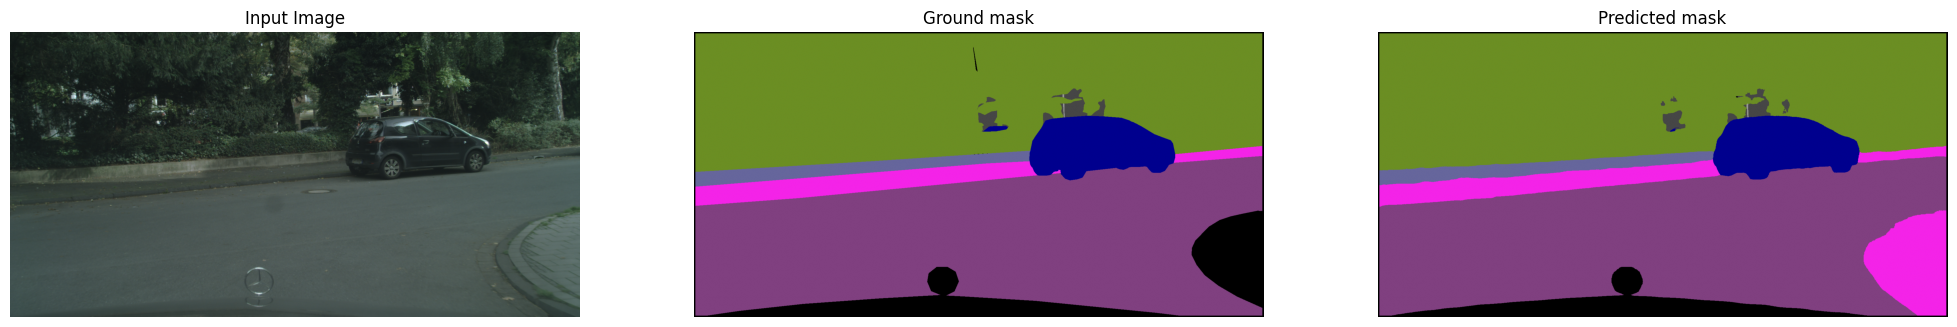

In [59]:
from torchvision import transforms
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)


sample=0
invimg=inv_normalize(img[sample])
outputx=output.detach().cpu()[sample]
encoded_mask=encode_segmap(seg[sample].clone())
decoded_mask=decode_segmap(encoded_mask.clone())
decoded_ouput=decode_segmap(torch.argmax(outputx,0))
fig,ax=plt.subplots(ncols=3,figsize=(25,50),facecolor='white')
ax[0].imshow(np.moveaxis(invimg.numpy(),0,2))

ax[1].imshow(decoded_mask)
ax[2].imshow(decoded_ouput)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Input Image')
ax[1].set_title('Ground mask')
ax[2].set_title('Predicted mask')
plt.savefig('result.png',bbox_inches='tight')